## Energy modeling with OMEGAlpes

Graphical representation of the energy model using the OMEGAlpes formalism.

![PV_self_consumption_optim](figures/example_PV_self_consumption.png)

First we will import all the necessary functions needed to build our model.

In [1]:
from python_scripts.NB_To_Modify_PV_self_consumption_utils import *

Then, we can introduce the dynamics linked to this case study in order to study the optimal energy management strategy of this house. Here, we choose to study a 24 hours scenario with a 5 minutes time step. Moreover the case study is thought to be occuring on the 10th of August 2016. We can now instanciate our class TimeUnit as follows:

In [2]:
time = TimeUnit(start='10/08/2016', periods=24*12, dt=1/12)

You are studying the period from 2016-08-10 00:00:00 to 2016-08-10 23:55:00


The number of configured *periods* is 24\*12 periods. Time time step *dt* is defined as 1/12 hours. We also could have defined our *time* object by configuring strarting and ending dates. The default starting date is the 01/01/2018.

We can then describe the energy model of our study case.
For the electrical grid, energy imports and exports are respectively represented by *VariableProductionUnit* and *VariableConsumptionUnit*, as the associated energy flows depend on the established consumption strategy.

In [11]:
exports = VariableConsumptionUnit(time, name="exports", 
                                  energy_type=elec)

Creating the exports.


In [12]:
imports = VariableProductionUnit(time, name="imports", pmax=6000,
                                 energy_type=elec)

Creating the imports.


In addition to grid energy import is the solar photovoltaic production (PV). This production cannot be controlled and will be modeled as a *FixedProductionUnit* with its production profile (pv_profile) as follows:

In [13]:
pv_profile = import_PV_profile_5_min()

In [14]:
pv_prod = FixedProductionUnit(time, name="pv_prod", p=pv_profile, 
                              energy_type=elec)

Creating the pv_prod.


Likewise, the domestic hot water consumption is considered as known on the whole day. It is defined as a *FixedConsumptionUnit* with a fixed consumption profile (dhw_load), with the following command:

In [15]:
dhw_load = import_domestic_hot_water_load_profile()
dhw = FixedConsumptionUnit(time, name="dhw", p=dhw_load,
                           energy_type=thermal)


Creating the dhw.


The two other electric loads have flexible starting time. The load profiles are known but they can be shifted in time. They will be modeled with *ShiftableConsumptionUnit*, respectively configured with the (washer_load) and the (dryer_load), as follows:

In [16]:
washer_load = import_clothes_washer_load_profiles()
washer = ShiftableConsumptionUnit(time, name="washer", 
                                  power_values=washer_load,  
                                  energy_type=elec)

Creating the washer.


The last electric load is the electric water heater that converts 90% of the inlet electricity into heat. It will be modeled as an *ElectricalToThermalConversionUnit* with a constant conversion factor as follows:

In [17]:
water_heater = ElectricalToThermalConversionUnit(
    time, name="water_heater", elec_to_therm_ratio=0.9)

Creating the water_heater_therm_prod.
Creating the water_heater_elec_cons.
Creating the water_heater.


Finally the hot water tank can be defined as a simple *StorageUnit* with a 6 kWh capacity, which cannot be discharged below 20% of its capacity and must have the same final state of charge as its initial one. A self-discharge rate of 5% per hour is added.

In [18]:
water_tank = StorageUnit(time, name="water_tank",  self_disch_t=0.05,
                         soc_min=0.2, energy_type=thermal,
                         ef_is_e0=True, capacity=6000)

Creating the water_tank.


Once the energy units are defined, they must connected to one another through energy nodes. In our study case, we have an electrical balance and a heat balance. Two energy nodes are then defined:

In [19]:
elec_node = EnergyNode(time, name="elec_node", 
                       energy_type=elec)

Creating the elec_node.


In [20]:
heat_node = EnergyNode(time, name="heat_node", 
                       energy_type=thermal)

Creating the heat_node.


The energy units are then connected to the energy nodes:

In [21]:
elec_node.connect_units(imports, exports, pv_prod, washer, 
                        water_heater.elec_consumption_unit)

In [22]:
heat_node.connect_units(dhw, water_tank, 
                        water_heater.thermal_production_unit)

### Adding external constraints and the optimization objective


Now we want to add our objective: maximizing the self-consumption over the day, i.e. the part of the PV pannels electricity production that is consummed in the individual house. In order to do so, we need to minimize the grid power imports: we can use the command *minimize_production* as follows:

In [23]:
imports.minimize_production()

### Launching the optimisation and plotting results

Now that the energy model is finalised and the constraints and objective are set, the optimisation can be launched


The first step is to create the OMEGAlpes optimisation meta-model and to add  the energy nodes to it.


In [24]:
model = OptimisationModel(time, name="example")

In [25]:
model.add_nodes(elec_node, heat_node)






--- Adding all variables to the model ---
Adding variable : imports_p
Adding variable : imports_e_tot
Adding variable : imports_u
Adding variable : exports_p
Adding variable : exports_e_tot
Adding variable : exports_u
Adding variable : pv_prod_p
Adding variable : pv_prod_e_tot
Adding variable : washer_p
Adding variable : washer_e_tot
Adding variable : washer_u
Adding variable : washer_start_up
Adding variable : washer_power_values
Adding variable : water_heater_elec_cons_p
Adding variable : water_heater_elec_cons_e_tot
Adding variable : water_heater_elec_cons_u
Adding variable : water_heater_therm_prod_p
Adding variable : water_heater_therm_prod_e_tot
Adding variable : water_heater_therm_prod_u
Adding variable : dhw_p
Adding variable : dhw_e_tot
Adding variable : water_tank_p
Adding variable : water_tank_e_tot
Adding variable : water_tank_u
Adding variable : water_tank_capacity
Adding variable : water_tank_e
Adding variable : water_tank_pc
Adding variable : water_tank_pd
Adding variab

In [26]:
model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 14.03353762626648 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : imports
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : exports
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : pv_prod
	Quantity : p
	Quantity : e_tot
Updating unit : washer
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up
	Quantity : power_values
Updating unit : water_heater_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : water_heater
Updating unit : water_heater_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_node
Updating unit : dhw
	Quantity : p
	Quantity : e_tot
Updating unit : water_tank
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f


It is now possible to view the results. Some commands can be directly used by importing them from the *plots* module: 


In [27]:
from omegalpes.general.utils.plots import *


Preparing to plot the energetic flows through the node elec_node.
	Add power from imports.
	Add power from exports.
	Add power from pv_prod.
	Add power from washer.
	Add power from water_heater_elec_cons.


([<matplotlib.lines.Line2D at 0x2360e153208>],
 <Figure size 576x396 with 1 Axes>)

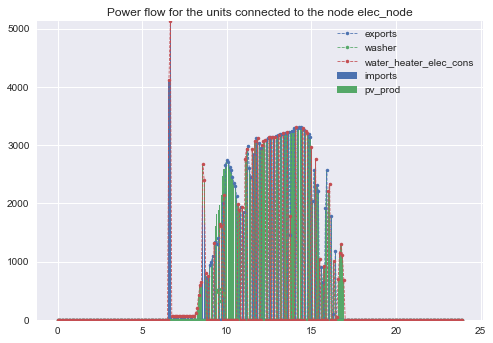

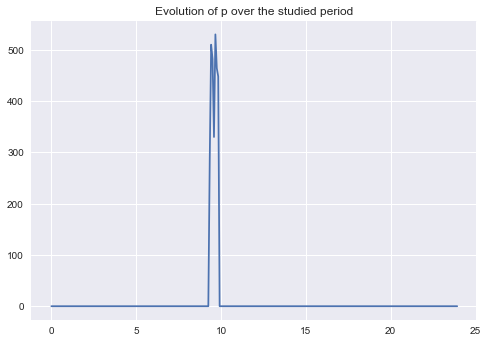

In [28]:
plot_node_energetic_flows(elec_node)
plot_quantity(time, washer.p)

Finally, the results can be exported as csv files with the function save_energy_flows of omegalpes/utils/output_data folder:

In [29]:
from omegalpes.general.utils.output_data import save_energy_flows

In [30]:
save_energy_flows(elec_node, heat_node, sep=';',
                  file_name='results/PV_example_results')
